# Theory for $\delta T(x)$ accounting for changes in WTG and CE
This starts from  $\delta h(x) = \delta h_{FT}(x) + \delta \epsilon(x)$ where $\delta \epsilon(x) = 0$ in CQE, to obtain an equation for $\delta T_s(x)$.

In [4]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import (get_temp_adiabat, get_delta_mse_mod_anom_theory, get_theory_prefactor_terms,
                                              decompose_temp_adiabat_anomaly, get_delta_temp_quant_theory, get_delta_temp_quant_theory_simple, 
                                              get_delta_temp_quant_theory_simple2)
from isca_tools.utils.stats import z_score_from_confidence_interval
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
from sklearn.linear_model import TheilSenRegressor
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [5]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag']        # only keep variables required to compute relative humidity and MSE
# var_keep = ['temp', 'sphum', 'height', 'ucomp', 'vcomp']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.


In [6]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [131]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 2/2 [00:15<00:00,  7.56s/it]


## Definition of Summer
Below I look at the months that are convecting, to deduce a good definition of summer.

In [132]:
# annual_mean_lat_plot = 64
annual_mean_lat_plot = 18
annual_mean_tau_ind = 0
ds_annual_mean = annual_mean(ds[annual_mean_tau_ind].sel(time=slice(use_time_start, np.inf)
                                                         ).sel(lat=[annual_mean_lat_plot, -annual_mean_lat_plot],
                                                               method='nearest').mean(dim='lon').isel(pfull=-1)).load()
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds[0].pfull)), ds[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

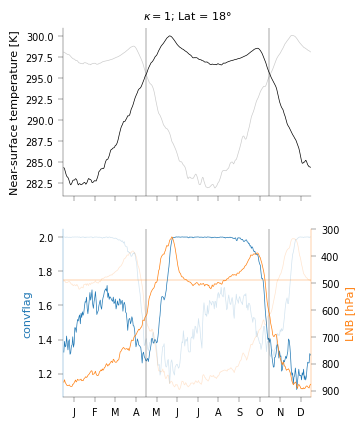

In [133]:
save_summer_def_fig = False

fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax2 = ax[1].twinx()
for i in range(ds_annual_mean.lat.size):
    ax[0].plot(ds_annual_mean.time-0.5, ds_annual_mean.temp[:, i], alpha=0.2 if ds_annual_mean.lat[i]<0 else 1, color='k')
    ax[1].plot(ds_annual_mean.time-0.5, ds_annual_mean.convflag[:, i], color=default_colors[0], alpha=0.2 if ds_annual_mean.lat[i]<0 else 1)
    ax2.plot(ds_annual_mean.time-0.5, lzb(ds_annual_mean.klzbs[:, i]), color=default_colors[1], alpha=0.2 if ds_annual_mean.lat[i]<0 else 1)
for i in range(len(ax)):
    if np.abs(ds_annual_mean.lat[0])>22:
        ax[i].axvline(5*30-1, color='k', lw=ax_linewidth)
        ax[i].axvline(8*30-1, color='k', lw=ax_linewidth)
        ax[i].axvline(11*30-1, color='k', lw=ax_linewidth, alpha=0.2)
        ax[i].axvline(2*30-1, color='k', lw=ax_linewidth, alpha=0.2)
    else:
        ax[i].axvline(4*30-1, color='k', lw=ax_linewidth)
        ax[i].axvline(10*30-1, color='k', lw=ax_linewidth)
ax2.axhline(pressure_ft_actual/100, color=default_colors[1], lw=ax_linewidth)
ax2.invert_yaxis()
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.spines[['right']].set_visible(True)
ax2.spines[['right']].set_color(default_colors[1])
ax[1].spines[['left']].set_color(default_colors[0])
ax[1].set_ylabel('convflag', color=default_colors[0])
ax2.set_ylabel('LNB [hPa]', color=default_colors[1])
ax[0].set_ylabel('Near-surface temperature [K]')
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
ax[0].set_title(f'$\kappa= {tau_lw[annual_mean_tau_ind]}$; Lat = {round(float(ds_annual_mean.lat[0]))}$\degree$')

if save_fig or save_summer_def_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/summer_definition_lat={annual_mean_lat_plot}.pdf", 
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [134]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
# 2 different methods for computing r_mean and sphum_mean - q calculates from sphum, while r calculates from rh.
r_mean = np.zeros((n_exp, n_lat))
z_mean = np.zeros((n_exp, n_pressure, n_lat))

lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation
# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
r_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting

with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.mean(dim='lon_time')
        rh_use = ds_all[i].sphum.isel(pfull=ind_surf)/sphum_sat(ds_all[i].temp.isel(pfull=ind_surf), p_surface)
        r_mean[i] = rh_use.mean(dim='lon_time')
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                z_quant3[i, :, k, j] = ds_all[i].height[:, k, use_ind].mean(dim='lon_time')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                r_quant3[i, k, j] = rh_use[k, use_ind].mean(dim='lon_time')
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)
# Compute sphum from rh values
sphum_quant3 = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3
sphum_mean = sphum_sat(temp_mean[:, ind_surf], p_surface) * r_mean
mse_quant3[:, ind_surf] = moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, z_quant3[:, ind_surf])
mse_quant3[:, ind_ft] = moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft])
mse_mean[:, ind_surf] = moist_static_energy(temp_mean[:, ind_surf], sphum_mean, z_mean[:, ind_surf])
mse_mean[:, ind_ft] = moist_static_energy(temp_mean[:, ind_ft], sphum_sat(temp_mean[:, ind_ft], pressure_ft_actual), z_mean[:, ind_ft])

100%|██████████| 3564/3564 [00:16<00:00, 218.90it/s]


In [135]:
print('Max % Deviations From Mean')
print('Temp:', 100*np.abs(np.average((temp_quant3[0, ind_surf]-temp_mean[0, ind_surf, :, np.newaxis])/temp_mean[0, ind_surf, :, np.newaxis], 
                                     axis=0, weights=lat_weights)).max())

print(f'RH:', 100*np.abs(np.average((r_quant3[0]-r_mean[0, :, np.newaxis])/r_mean[0, :, np.newaxis], 
                                            axis=0, weights=lat_weights)).max())

Max % Deviations From Mean
Temp: 2.6177868847478183
RH: 7.567305949914119


## Relating $z_{FT}$ to $T_{500}$ and $T_s$
A crucial aspect to this theory is relating the geopotential height $z_{FT}$ to near-surface temperature $T$ and free troposphere temperature $T_{FT}$.

We start with two equations, from Zhang 2023. The first combines hydrostatic balance and the ideal gas law. The second assumes a constant lapse rate, $\Gamma$, for integration processes.

$d\ln p = -\frac{g}{RT(p)}dz$;      $z(p) - z_s = \frac{T_s - T(p)}{\Gamma}$

Combining the two, we get $d\ln p = \frac{g}{R\Gamma}d\ln T$.

Integrating between the free troposphere at 500hPa and surface at 1000hPa, we get:
$\ln(\frac{1000}{500}) = \ln 2 = \frac{g}{R\Gamma}\ln(\frac{T_s}{T_{500}})$ or $\frac{1}{\Gamma} = \frac{R\ln 2}{g\ln(\frac{T_s}{T_{500}})}$

We also have the $z$ equation applied at 500hPa: $z_{500} - z_s = \frac{T_s - T_{500}}{\Gamma}$. Combining the two, we get:
$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g\ln(\frac{T_s}{T_{500}})}$

We can re-write the denominator in $\ln(1+x)$ form as $\ln(1+\frac{T_s-T_{500}}{T_{500}})$. Here $x=\frac{T_s-T_{500}}{T_{500}}$ and is small. Max value in tropics is about 0.15. 

The taylor series is $\frac{1}{\ln(1+x)} \approx \frac{1}{x} + \frac{1}{2} - \frac{x}{12} + ...$. Because $x$ is small, I propose keeping just the first two terms. In which case, we get:

$z_{500} - z_s \approx \frac{R\ln 2(T_s - T_{500})}{g}(\frac{T_{500}}{T_s-T_{500}} + \frac{1}{2}) = \frac{R\ln 2}{2g}(T_s + T_{500})$

The plots below shows that the taylor approximation is pretty accurate, and they are both decent approximations for the actual geopotential height.

In [136]:
def get_z_theory(temp_surf, temp_ft, taylor=True, pressure_surf=p_surface, pressure_ft=pressure_ft_actual):
    lnp_prefactor = R * np.log(pressure_surf/pressure_ft) / g
    if taylor:
        return lnp_prefactor/2 * (temp_surf + temp_ft)
    else:
        return lnp_prefactor * (temp_surf - temp_ft) / np.log(temp_surf/temp_ft)

z_theory_quant3 = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['full', 'taylor']}
z_theory_mean = {key: np.zeros((n_exp, n_lat)) for key in ['full', 'taylor']}
for i in range(n_exp):
    for key in z_theory_quant3:
        z_theory_quant3[key][i] = get_z_theory(temp_quant3[i, ind_surf], temp_quant3[i, ind_ft], True if key=='taylor' else False)
        z_theory_mean[key][i] = get_z_theory(temp_mean[i, ind_surf], temp_mean[i, ind_ft], True if key=='taylor' else False)

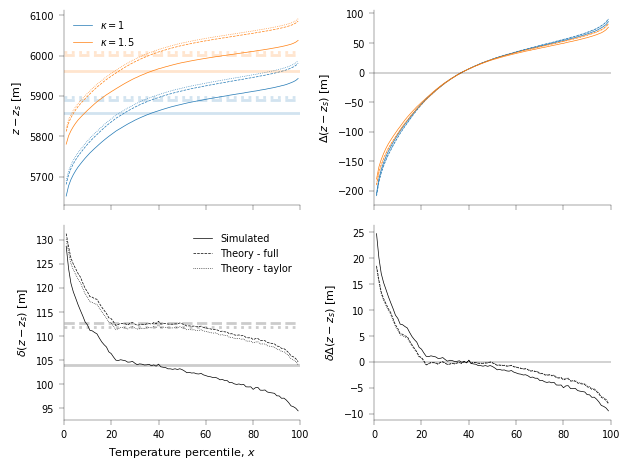

In [145]:
save_z_ft_fig = True
fig, ax = plt.subplots(2,2, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True)
linestyles_use = {'full': '--', 'taylor': ':'}
for i in range(n_exp):
    ax[0, 0].plot(quantiles_all, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i],
               label=f'$\\kappa={tau_lw[i]}$')
    ax[0, 0].axhline(np.average(z_mean[i, ind_ft]-z_mean[i, ind_surf], axis=0, weights=lat_weights), color=default_colors[i], lw=2, alpha=0.2)
    for key in z_theory_quant3:
        ax[0, 0].plot(quantiles_all, 
                   np.average(z_theory_quant3[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                   linestyle=linestyles_use[key])
        ax[0, 0].axhline(np.average(z_theory_mean[key][i], axis=0, weights=lat_weights), color=default_colors[i], 
                      linestyle=linestyles_use[key], lw=2, alpha=0.2)
ax[1, 0].plot(quantiles_all, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), color='k',
           label='Simulated')
ax[1, 0].axhline(np.average(np.diff(z_mean[:, ind_ft]-z_mean[:, ind_surf], axis=0)[0], axis=0, weights=lat_weights), 
              color='k', lw=2, alpha=0.2)
for key in z_theory_quant3:
    ax[1, 0].plot(quantiles_all, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0], axis=0, weights=lat_weights), 
               color='k', linestyle=linestyles_use[key], label=f'Theory - {key}')
    ax[1, 0].axhline(np.average(z_theory_mean[key][1]-z_theory_mean[key][0], axis=0, weights=lat_weights), color='k', 
                  linestyle=linestyles_use[key], lw=2, alpha=0.2)

for i in range(n_exp):
    ax[0, 1].plot(quantiles_all, 
               np.average(z_quant3[i, ind_ft] - z_quant3[i, ind_surf] - (z_mean[i, ind_ft]-z_mean[i, ind_surf])[:, np.newaxis], 
                          axis=0, weights=lat_weights), color=default_colors[i], label=f'$\\kappa={tau_lw[i]}$')
    for key in z_theory_quant3:
        ax[0, 1].plot(quantiles_all, np.average(z_theory_quant3[key][i] - z_theory_mean[key][i][:, np.newaxis], axis=0, weights=lat_weights),
                      color=default_colors[i], linestyle=linestyles_use[key])
ax[1, 1].plot(quantiles_all, 
           np.average(np.diff(z_quant3[:, ind_ft] - z_quant3[:, ind_surf] - (z_mean[:, ind_ft]-z_mean[:, ind_surf])[:, :, np.newaxis], axis=0)[0], 
                      axis=0, weights=lat_weights), color='k')
for key in z_theory_quant3:
    ax[1, 1].plot(quantiles_all, 
                   np.average(z_theory_quant3[key][1]-z_theory_quant3[key][0] - (z_theory_mean[key][1]-z_theory_mean[key][0])[:, np.newaxis], 
                              axis=0, weights=lat_weights), color='k', linestyle=linestyles_use[key], label=f'Theory - {key}') 

ax[0, 0].legend()
ax[1, 0].legend()
ax[0, 0].set_ylabel('$z-z_s$ [m]')
ax[0, 1].set_ylabel('$\Delta (z-z_s)$ [m]')
ax[1, 0].set_ylabel('$\delta (z-z_s)$ [m]')
ax[1, 1].set_ylabel('$\delta \Delta (z-z_s)$ [m]')
ax[1, 0].set_xlabel(percentile_label)
ax[0, 0].set_xlim(0, 100)
ax[0, 1].axhline(0, color='k', lw=ax_linewidth)
ax[1, 1].axhline(0, color='k', lw=ax_linewidth)
plt.tight_layout()
if save_fig or save_z_ft_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/z_ft_approx_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Theory - Only $z$ approximation
I start the theory with the exact equation $h_s(x) = h_{FT}(x) + \epsilon(x)$ where $\epsilon$ indicates the deviation from convective equilibrium (CE). 

If I take changes with warming and then only make the approximation:
$\delta (z_{500} - z_s) \approx \frac{R\ln 2}{2g} \delta (T_s + T_{FT})$, I can obtain an estimate for $\delta T_s(x)$ through solving:

$$\delta \left((c_p - R^{\dagger})T_s(x) + L_v q_s(x)\right) \approx \delta \left((c_p + R^{\dagger})T_{FT}(x) + L_v q^*_{FT}(x)\right) + \delta \epsilon(x)$$

I do this numerically below (without any taylor approximations).

We see that wherever the approximation for $\delta (z_{500} - z_s)$ is overestimated by the taylor series above, $\delta T_s(x)$ is also over-estimated.

Above we see that the theory does a better job at approximating the change in geopotential height anomaly ($\delta \Delta z$) rather than change in geopotential height ($\delta z$). As such, when we divide the theoretical $\delta T_s(x)$ by the theoretical $\delta \overline{T_s}$, the theory looks better below.

In [138]:
def delta_temp_fit_func(temp_surf_change: float, temp_surf0: float, r_surf: np.ndarray, temp_ft: np.ndarray, epsilon: np.ndarray,
                        pressure_surf: float = p_surface, pressure_ft: float = pressure_ft_actual) -> float:
    """
    This finds $\delta T_s(x)$ such that $\delta h(x) = \delta h_{FT}^*(x) + \delta \epsilon(x)$

    Args:
        temp_surf_change: float
            Change in temperature at `pressure_surf` in Kelvin.
        temp_surf0:
            Actual temperature at `pressure_surf` in reference climate in Kelvin.
        r_surf: float [n_exp]
            Actual relative humidity at `pressure_surf`.
        temp_ft: float [n_exp]
            Temperature at `pressure_ft` in Kelvin for each experiment.
        epsilon: float [n_exp]
            $\epsilon = h_s(x) - h_{FT}^*(x)$ in *kJ/kg*. It quantifies the deviation from CE and CQE.
        pressure_surf:
            Pressure at near-surface in *Pa*.
        pressure_ft:
            Pressure at free troposphere level in *Pa*.
    Returns:
        MSE discrepancy: difference between surface and free troposphere saturated MSE in *kJ/kg*.
    """
    n_exp = len(r_surf)
    R_mod = R * np.log(pressure_surf / pressure_ft) / 2
    mse_mod_surf_cold = moist_static_energy(temp_surf0, r_surf[0] * sphum_sat(temp_surf0, pressure_surf), height=0, c_p_const=c_p - R_mod)
    mse_mod_surf_hot = moist_static_energy(temp_surf0 + temp_surf_change, r_surf[1] * sphum_sat(temp_surf0 + temp_surf_change, pressure_surf), 
                                           height=0, c_p_const=c_p - R_mod)
    mse_mod_ft = [moist_static_energy(temp_ft[i], sphum_sat(temp_ft[i], pressure_ft), height=0, c_p_const=c_p + R_mod) for i in range(n_exp)]
    mse_mod_surf_change = mse_mod_surf_hot - mse_mod_surf_cold
    mse_mod_ft_change = mse_mod_ft[1] - mse_mod_ft[0]
    epsilon_change = epsilon[1] - epsilon[0]
    return mse_mod_surf_change - mse_mod_ft_change - epsilon_change

def get_temp_change_theory(temp_surf0, r_surf, temp_ft, epsilon, pressure_surf = p_surface, pressure_ft = pressure_ft_actual, taylor_level='linear'):
    R_mod, q_sat_surf, alpha_surf, beta_s1, beta_s2, _ = get_theory_prefactor_terms(temp_surf0, pressure_surf, pressure_ft, r_surf[0] * 
                                                                                    sphum_sat(temp_surf0, pressure_surf))
    _, q_sat_ft, alpha_ft, beta_ft1, beta_ft2, _ = get_theory_prefactor_terms(temp_ft[0], pressure_surf, pressure_ft)
    r_change = r_surf[1] - r_surf[0]
    temp_ft_change = temp_ft[1] - temp_ft[0]
    epsilon_change = (epsilon[1] - epsilon[0]) * 1000
    
    coef_surf_linear = beta_s1
    if 'nl' in taylor_level:
        coef_surf_linear = coef_surf_linear + L_v * alpha_surf * q_sat_surf * r_change
        
    if 'squared' in taylor_level:
        coef_surf_squared = 0.5 * beta_s2 / temp_surf0
        coef_ft_squared = 0.5 * beta_ft2 / temp_ft[0]
    else:
        coef_surf_squared = 0
        coef_ft_squared = 0
    coef_ft_linear = beta_ft1
    mse_ft_change_approx = coef_ft_squared * temp_ft_change**2 + coef_ft_linear * temp_ft_change
    
    quadratic_constant = L_v * q_sat_surf * r_change - mse_ft_change_approx - epsilon_change
    return np.roots([coef_surf_squared, coef_surf_linear, quadratic_constant])[-1]

In [139]:
epsilon_mean = np.asarray([mse_mean[i, ind_surf] - mse_mean[i, ind_ft] for i in range(n_exp)])
epsilon_quant3 = np.asarray([mse_quant3[i, ind_surf] - mse_quant3[i, ind_ft] for i in range(n_exp)])

temp_mean_change = temp_mean[1, ind_surf] - temp_mean[0, ind_surf]
temp_quant_change = temp_quant3[1, ind_surf] - temp_quant3[0, ind_surf]
temp_mean_change_theory = {key: np.zeros(n_lat) for key in ['just_z', 'taylor', 'taylor_nl']}
temp_quant_change_theory = {key: np.zeros((n_lat, n_quant_all)) for key in ['just_z', 'taylor', 'taylor_nl']}
for i in range(n_lat):
    temp_mean_change_theory['just_z'][i] = scipy.optimize.fsolve(delta_temp_fit_func, 5, args=(temp_mean[0, ind_surf, i], r_mean[:, i], 
                                                                                        temp_mean[:, ind_ft, i], epsilon_mean[:, i]))
    temp_mean_change_theory['taylor'][i] = get_temp_change_theory(temp_mean[0, ind_surf, i], r_mean[:, i], temp_mean[:, ind_ft, i], 
                                                                  epsilon_mean[:, i])
    temp_mean_change_theory['taylor_nl'][i] = get_temp_change_theory(temp_mean[0, ind_surf, i], r_mean[:, i], temp_mean[:, ind_ft, i],  
                                                                     epsilon_mean[:, i], taylor_level='nl')
    for j in range(n_quant_all):
        temp_quant_change_theory['just_z'][i, j] = scipy.optimize.fsolve(
            delta_temp_fit_func, 5, args=(temp_quant3[0, ind_surf, i, j], r_quant3[:, i, j], temp_quant3[:, ind_ft, i, j], epsilon_quant3[:, i, j]))
        temp_quant_change_theory['taylor'][i, j] = get_temp_change_theory(temp_quant3[0, ind_surf, i, j], r_quant3[:, i, j], 
                                                                          temp_quant3[:, ind_ft, i, j], epsilon_quant3[:, i, j])
        temp_quant_change_theory['taylor_nl'][i, j] = get_temp_change_theory(temp_quant3[0, ind_surf, i, j], r_quant3[:, i, j], 
                                                                          temp_quant3[:, ind_ft, i, j], epsilon_quant3[:, i, j], taylor_level='nl')
# scipy.optimize.fsolve(delta_temp_fit_func, 273, args=(temp_surf, sphum_surf, pressure_surf, pressure_ft))

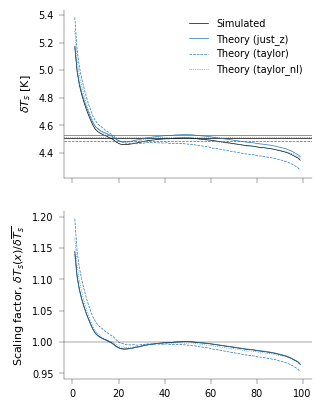

In [140]:
save_theory1_fig = True
linestyles_use = ['-', '--', ':']
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax[0].plot(quantiles_all, np.average(temp_quant_change, axis=0, weights=lat_weights), color='k', label='Simulated')
ax[0].axhline(np.average(temp_mean_change, axis=0, weights=lat_weights), color='k')
ax[1].plot(quantiles_all, np.average(temp_quant_change/temp_mean_change[:, np.newaxis], axis=0, weights=lat_weights), color='k', label='Theory')
for i, key in enumerate(temp_quant_change_theory):
    ax[0].plot(quantiles_all, np.average(temp_quant_change_theory[key], axis=0, weights=lat_weights), color=default_colors[0], 
               label=f'Theory ({key})', linestyle=linestyles_use[i])
    ax[0].axhline(np.average(temp_mean_change_theory[key], axis=0, weights=lat_weights), color=default_colors[0], linestyle=linestyles_use[i])
    ax[1].plot(quantiles_all, np.average(temp_quant_change_theory[key]/temp_mean_change_theory[key][:, np.newaxis], axis=0,
                                         weights=lat_weights), color=default_colors[0], linestyle=linestyles_use[i])
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].legend()
ax[0].set_ylabel('$\delta T_s$ [K]')
ax[1].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T_s}$')

if save_fig or save_theory1_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/theory1_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Theory relating change in $T_s(x)$ to change in $\overline{T_s}$
If I make the assumption of $\Delta (z_{500} - z_s) \approx \frac{R\ln 2}{2g}(\Delta T_s + \Delta T_{FT})$ and nothing more in a given climate, I can obtain the equation:

$$(c_p - R^{\dagger})\Delta T_s(x) + L_v \Delta q_s(x) \approx (c_p + R^{\dagger})\Delta T_{FT}(x) + L_v \Delta q^*_{FT}(x) + \Delta \epsilon(x)$$

If I also take a linear taylor series, I obtain:

$$\beta_{s1}\Delta T_s(x) + L_v \overline{q_s^*} \Delta r_s(x) \approx \beta_{FT1}\Delta T_{FT}(x) + \Delta \epsilon(x)$$

Below I see how good an approximation this is for $\Delta T_s$. Both these equations do very well for summer, so it makes sense to use the latter going foreward as it is more simple.

In [141]:
def temp_s_anom_fit_func(temp_surf_anom, temp_surf_mean, r_surf_mean, r_surf_quant, temp_ft_mean, temp_ft_quant, epsilon_mean, epsilon_quant,
                        pressure_surf = p_surface, pressure_ft = pressure_ft_actual):
    R_mod = R * np.log(pressure_surf / pressure_ft) / 2
    sphum_anom = r_surf_quant * sphum_sat(temp_surf_mean+temp_surf_anom, pressure_surf) - r_surf_mean * sphum_sat(temp_surf_mean, pressure_surf)
    mse_mod_anom_surf = (c_p - R_mod) * temp_surf_anom + L_v * sphum_anom
    mse_mod_anom_ft = (c_p + R_mod) * (temp_ft_quant - temp_ft_mean) + L_v * (sphum_sat(temp_ft_quant, pressure_ft) - 
                                                                              sphum_sat(temp_ft_mean, pressure_ft))
    epsilon_anom = (epsilon_quant - epsilon_mean) * 1000
    return mse_mod_anom_surf - mse_mod_anom_ft - epsilon_anom

def get_temp_s_anom_theory(temp_surf_mean, r_surf_mean, r_surf_quant, temp_ft_mean, temp_ft_quant, epsilon_mean, epsilon_quant, 
                           pressure_surf = p_surface, pressure_ft = pressure_ft_actual, use_taylor=False):
    if not use_taylor:
        return scipy.optimize.fsolve(temp_s_anom_fit_func, 5, args=(temp_surf_mean, r_surf_mean, r_surf_quant, temp_ft_mean, 
                                                                    temp_ft_quant, epsilon_mean, epsilon_quant, pressure_surf, pressure_ft))
    else:
        epsilon_anom = (epsilon_quant - epsilon_mean) * 1000
        r_anom = r_surf_quant - r_surf_mean
        temp_ft_anom = temp_ft_quant - temp_ft_mean
        
        _, q_sat_surf, _, beta_s1, _, _ = get_theory_prefactor_terms(temp_surf_mean, pressure_surf, pressure_ft, r_surf_mean * 
                                                                                    sphum_sat(temp_surf_mean, pressure_surf))
        _, _, _, beta_ft1, _, _ = get_theory_prefactor_terms(temp_ft_mean, pressure_surf, pressure_ft)
        return (beta_ft1 * temp_ft_anom + epsilon_anom - L_v * q_sat_surf * r_anom) / beta_s1

In [142]:
temp_s_anom_theory = {key: np.zeros((n_exp, n_lat, n_quant_all)) for key in ['just_z', 'taylor']}
for key in temp_s_anom_theory:
    for i in range(n_exp):
        for j in range(n_lat):
            for k in range(n_quant_all):
                temp_s_anom_theory[key][i, j, k] = get_temp_s_anom_theory(temp_mean[i, ind_surf, j], r_mean[i, j], r_quant3[i, j, k], 
                                                                          temp_mean[i, ind_ft, j], temp_quant3[i, ind_ft, j, k], 
                                                                          epsilon_mean[i, j], epsilon_quant3[i, j, k], use_taylor='taylor' in key)

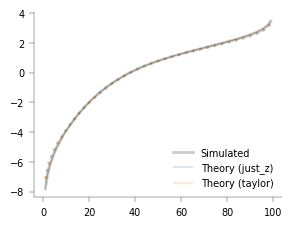

In [143]:
save_temp_s_anom_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
linestyles_use = ['-', ':']
for i in range(n_exp):
    ax.plot(quantiles_all, np.average(temp_quant3[i, ind_surf] - temp_mean[i, ind_surf][:, np.newaxis], axis=0,weights=lat_weights), 
            color='k', label='Simulated' if i==0 else None, linestyle=linestyles_use[i], lw=2, alpha=0.2)
    for j, key in enumerate(temp_s_anom_theory):
        ax.plot(quantiles_all, np.average(temp_s_anom_theory[key][i], axis=0,weights=lat_weights), 
                color=default_colors[j], label=f'Theory ({key})' if i==0 else None, linestyle=linestyles_use[i], lw=ax_linewidth)
ax.legend()

if save_fig or save_temp_s_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_s_anom_{region}_{season}.pdf",
                                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)